In [1]:
# dependencies import
from common_dependencies import *
import model_versions as mv
logger = logging.getLogger(f'main.model_train')
# детерминация случайных величин, отвечающих за выбор первоначальных весов и биасов

# Чтение и подготовка данных

## Параметры будующей модели

In [2]:
SEED = 200 # 290
tf.compat.v1.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)
CROP_SIZE = 16
MODEL_VER = 14
MODEL_NUM = 5
PATH_TO_SAVE_MODEL = pathlib.Path(f'networks/CNN/')

## Параметры обучающих выборок

In [3]:
# train params that can be easily changed
#CROP_STEP = 1
MAX_VAL = 1000
XSHIFT = 200
dataset_desc = {'train': (DatasetPartDescription(PATH_TO_DATA['run_1'],DataCrop(100,0,270,MAX_VAL),SlidingCrop(CROP_SIZE,1),XSHIFT)
                          #DatasetPartDescription(PATH_TO_DATA['run_2'],DataCrop(0,0,MAX_VAL,60),SlidingCrop(CROP_SIZE,1),XSHIFT)
                          
                         ,),
                'val': (DatasetPartDescription(PATH_TO_DATA['run_2'],DataCrop(0,0,MAX_VAL,40),SlidingCrop(CROP_SIZE,1),XSHIFT)
                        #DatasetPartDescription(PATH_TO_DATA['run_2'],DataCrop(0,60,MAX_VAL,20),SlidingCrop(CROP_SIZE,1),XSHIFT)
                        
                        ,)
               }

## Чтение и подготовка данных обучающих выборок

In [4]:
#входные и выходные данные
# reading
dataset = {'train':dict(zip(['x','y','bin'], [np.array(list(gen)) for gen in chain_dataset_gens(dataset_desc['train'])])),
           'val':dict(zip(['x','y','bin'], [np.array(list(gen)) for gen in chain_dataset_gens(dataset_desc['val'])]))}

main ::      get_dataset_gen() :: start
main.custom_modules.data_worker.data_worker ::     get_x_and_y_data() :: 
    Read detectors data shape: (115, 400)
    Read defect data shape: (115, 400)
main.custom_modules.data_worker.data_worker ::       normalize_data() :: 
    The arr max before normalization: 44.5
    The arr min before normalization: 0.0
    The arr max after normalization: 1.0
    The arr min after normalization: 0.0
main.custom_modules.data_worker.data_worker ::       normalize_data() :: 
    The arr max before normalization: 62.992
    The arr min before normalization: -61.968
    The arr max after normalization: 1.0
    The arr min after normalization: 0.0
main.custom_modules.data_worker.data_worker ::       normalize_data() :: 
    The arr max before normalization: 4.5
    The arr min before normalization: 0.0
    The arr max after normalization: 1.0
    The arr min after normalization: 0.0
main.custom_modules.data_worker._ndarray_utils :: extend_ndarray_for_crops_di

## Размерности данных в обучающих выборках

In [5]:
# displaying
logger.debug('Dataset')
for dataset_part_name, dataset_part in dataset.items():
    logger.debug('|'*8+dataset_part_name+'|'*8)
    for data_part_name, data_part in dataset_part.items():
        logger.debug(f'{data_part_name}.shape: {data_part.shape}')

main.model_train ::             <module>() :: Dataset
main.model_train ::             <module>() :: ||||||||train||||||||
main.model_train ::             <module>() :: x.shape: (25500, 16, 16, 64)
main.model_train ::             <module>() :: y.shape: (25500, 16, 16)
main.model_train ::             <module>() :: bin.shape: (25500, 1)
main.model_train ::             <module>() :: ||||||||val||||||||
main.model_train ::             <module>() :: x.shape: (9625, 16, 16, 64)
main.model_train ::             <module>() :: y.shape: (9625, 16, 16)
main.model_train ::             <module>() :: bin.shape: (9625, 1)


## Какие части 2 файлов с данными относятся к конкретным выборкам (к тренировочной, тестовой, валидационной)

main.custom_modules.data_worker.data_worker ::     get_x_and_y_data() :: 
    Read detectors data shape: (115, 400)
    Read defect data shape: (115, 400)


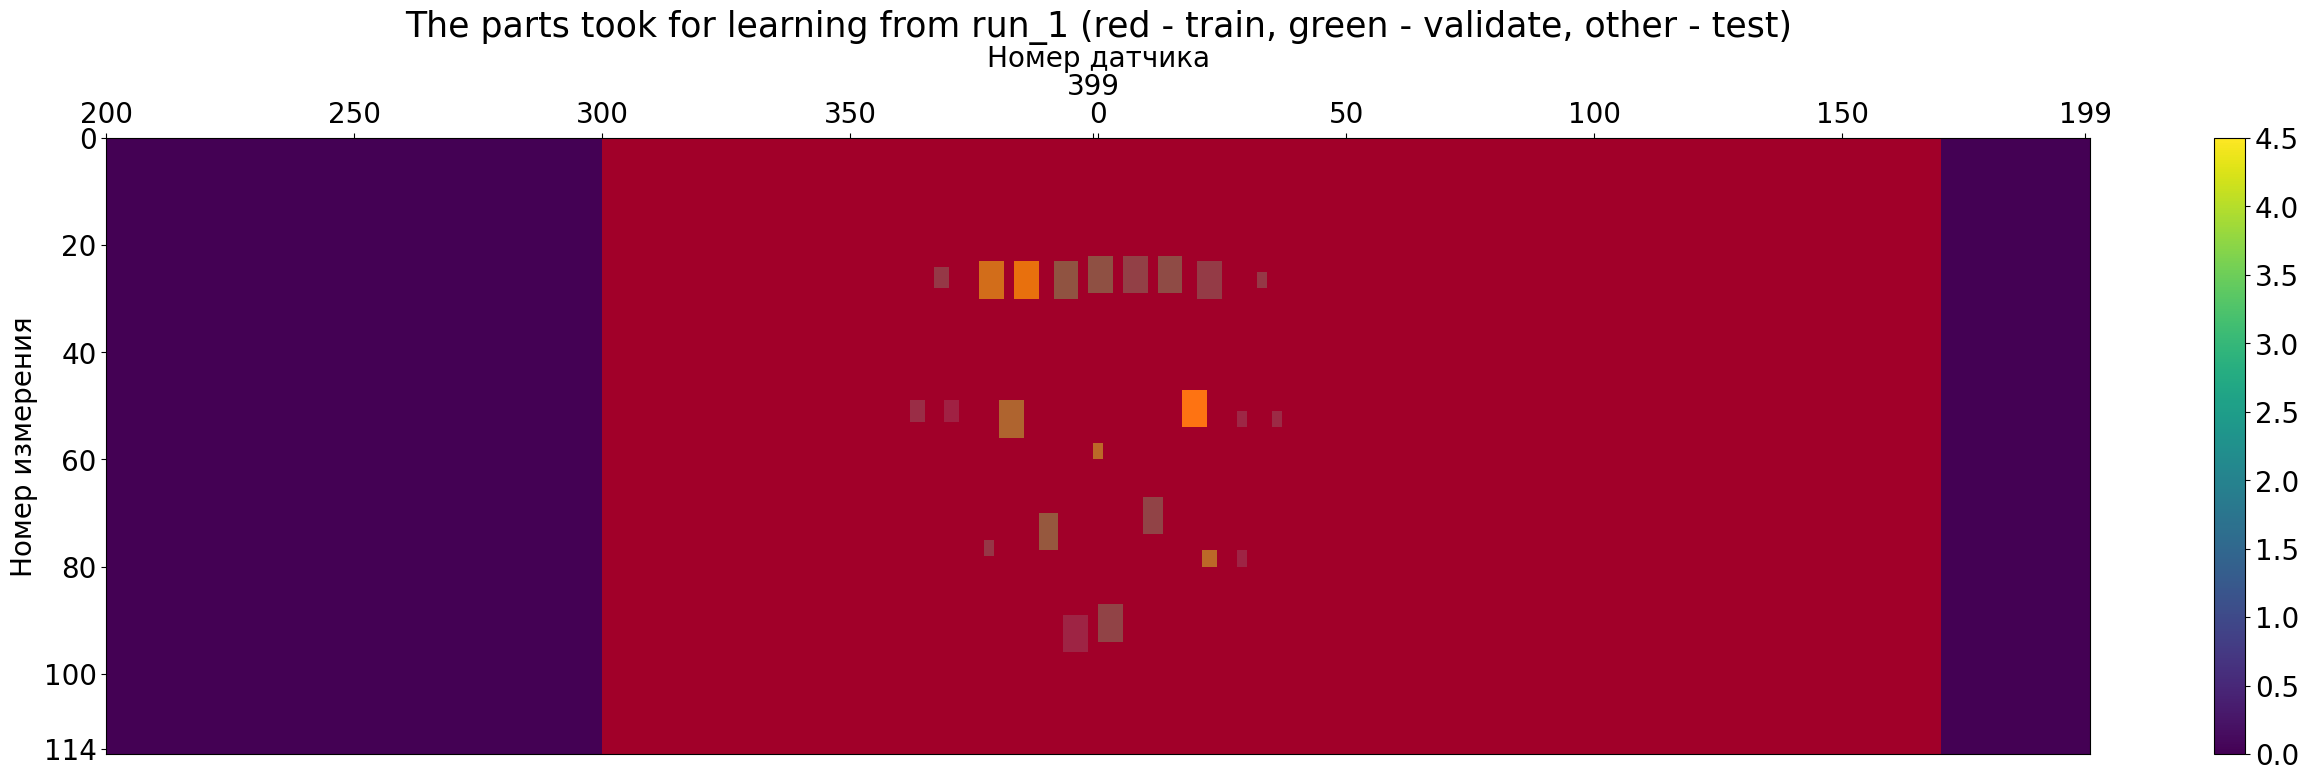

main.custom_modules.data_worker.data_worker ::     get_x_and_y_data() :: 
    Read detectors data shape: (119, 400)
    Read defect data shape: (119, 400)


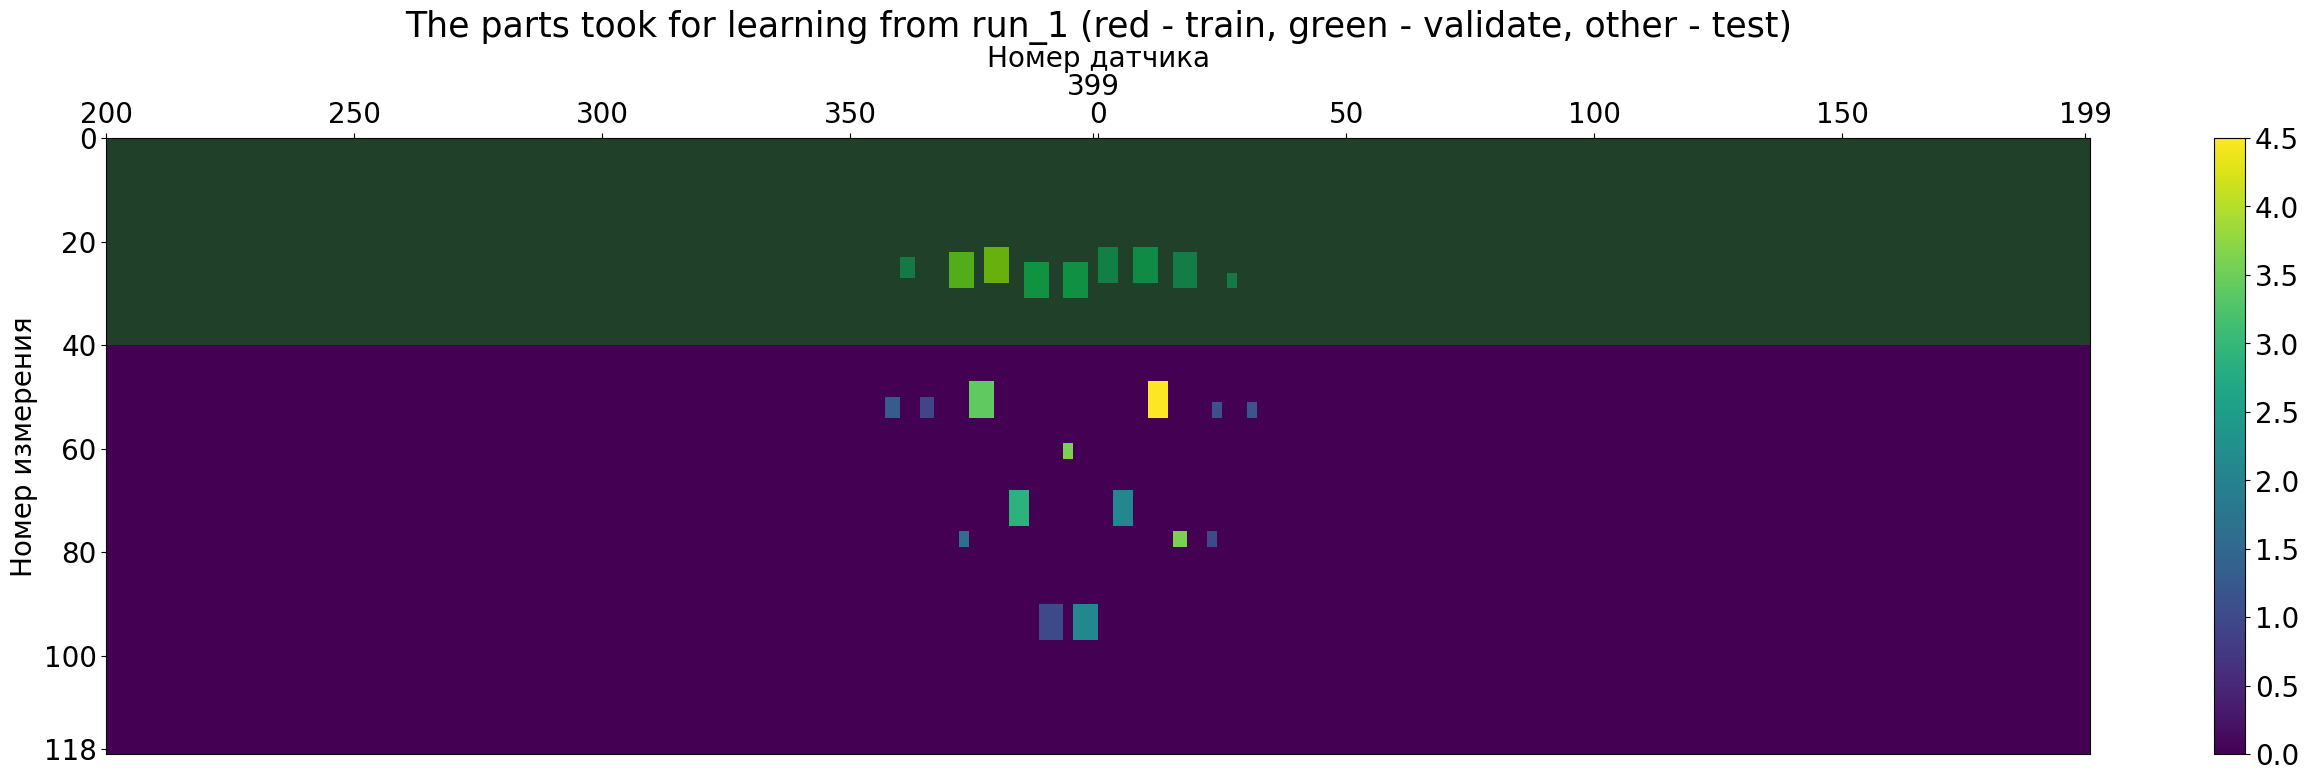

In [6]:
#выборка данных
# show parts took for learning
all_rects = {'run_1': {'train':None,'val':None}, 
             'run_2': {'train':None,'val':None}}
rects_colors = {'train':'red', 'val':'green'}

for run_name in all_rects.keys():
    x_df, y_df = dw.get_x_and_y_data(*PATH_TO_DATA[run_name])
    x_df = None
    y_df = dw.roll_df(y_df, XSHIFT, 1)
    for dataset_part_name in all_rects[run_name].keys():
        # get all DatasetPartDescription for train, val or test
        dataset_part_desc = dataset_desc[dataset_part_name]
        # get all DatasetPartDescription for current run_name (run_1 or run_2)
        dataset_part_desc = [dataset_part for dataset_part in dataset_part_desc if re.findall(r'run_\d', dataset_part.data_path_tuple[0])[0] == run_name]
        # put rects list to all_rects[run_name][dataset_part_name]
        all_rects[run_name][dataset_part_name] = [Rectangle((dataset_part.file_data_crop.left, dataset_part.file_data_crop.top), 
                           dataset_part.file_data_crop.width, dataset_part.file_data_crop.height, 
                           facecolor=rects_colors[dataset_part_name], alpha=0.5) for dataset_part in dataset_part_desc]
    res_rects = list(itertools.chain(*[run_rects for run_rects_name, run_rects in all_rects[run_name].items()]))
    if res_rects:
        dw.draw_defects_map_with_rectangles_owerlap(y_df, res_rects, title = f'The parts took for learning from run_1 (red - train, green - validate, other - test)')

# Создание и обучение модели

## Создание модели

In [7]:
#///////////////////////////////// для компиляции 

CMP_learning_rate = 0.005 # шаг сходимости back propogation
#CMP_solver = keras.optimizers.Adam(CMP_learning_rate) # оптимизатор
CMP_solver = keras.optimizers.SGD(CMP_learning_rate) # оптимизатор
CMP_loss_funcs = keras.losses.BinaryCrossentropy() #BinaryCrossentropy() 
CMP_metrics = [keras.metrics.BinaryAccuracy(name='BinaryAccuracy'),
               keras.metrics.MeanSquaredError(name='MeanSquaredError'),
               keras.metrics.TruePositives(name='TruePositives'),
               keras.metrics.FalsePositives(name='FalsePositives'),
               keras.metrics.TrueNegatives(name='TrueNegatives'),
               keras.metrics.FalseNegatives(name='FalseNegatives'),     
               keras.metrics.Precision(name='Precision'),
               keras.metrics.Recall(name='Recall'),
               keras.metrics.AUC(name='ROC_AUC', curve='ROC'),
               keras.metrics.AUC(name='PR_AUC', curve='PR')]

In [8]:
augment_data = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(1),
  layers.RandomTranslation(0.4,0.4,fill_mode="reflect"),
  layers.RandomZoom(0.2,0.2,fill_mode="reflect")
])

input_data = Input((16,16,64), name = 'input_data')

aug_data = augment_data(input_data)

# 12
dconv_1_1 = Conv2D(128, (3,3), dilation_rate=(2, 2), activation='relu', name='dconv_1_1')(aug_data)

# 6
dconv_1_2 = Conv2D(128, (3,3), dilation_rate=(5, 5), activation='relu', name='dconv_1_2')(aug_data)
up_1_2 = UpSampling2D(2, interpolation='bilinear', name='up_1_2') (dconv_1_2)

# 4
dconv_1_3 = Conv2D(128, (3,3), dilation_rate=(6, 6), activation='relu', name='dconv_1_3')(aug_data)
up_1_3 = UpSampling2D(3, interpolation='bilinear', name='up_1_3') (dconv_1_3)

# 2
dconv_1_4 = Conv2D(128, (3,3), dilation_rate=(7, 7), activation='relu', name='dconv_1_4')(aug_data)
up_1_4 = UpSampling2D(6, interpolation='bilinear', name='up_1_4') (dconv_1_4)


conc_1_1 = concatenate([dconv_1_1, up_1_2, up_1_3, up_1_4],axis=3, name='conc_1_1')


conv_2_1 = Conv2D(512, (3,3), dilation_rate=(2, 2), activation='relu', padding='same', name='conv_2_1')(conc_1_1)
conv_2_2 = Conv2D(512, (3,3), dilation_rate=(2, 2), activation='relu', padding='same', name='conv_2_2')(conv_2_1)
conv_2_3 = Conv2D(512, (3,3), dilation_rate=(2, 2), activation='relu', padding='same', name='conv_2_3')(conv_2_2)
pool_2_1 = MaxPooling2D((2,2), strides=2, name='pool_2_1')(conv_2_3)

conv_2_4 = Conv2D(1024, (2,2), activation='relu', name='conv_2_4')(pool_2_1)
conv_2_5 = Conv2D(1024, (2,2), activation='relu', name='conv_2_5')(conv_2_4)
conv_2_6 = Conv2D(1024, (2,2), activation='relu', name='conv_2_6')(conv_2_5)
conv_2_7 = Conv2D(1024, (2,2), activation='relu', name='conv_2_7')(conv_2_6)
pool_2_2 = MaxPooling2D((2,2), strides=2, name='pool_2_2')(conv_2_7)

d_4_1 = Dense(1024, activation='linear', name='d_4_1')(Flatten(name='flat_3_1')(pool_2_2))
d_4_2 = Dense(512, activation='linear', name='d_4_2')(d_4_1)
d_4_3 = Dense(256, activation='linear', name='d_4_3')(d_4_2)
d_4_4 = Dense(128, activation='linear', name='d_4_4')(d_4_3)
d_4_5 = Dense(64, activation='linear', name='d_4_5')(d_4_4)
d_4_6 = Dense(16, activation='linear', name='d_4_6')(d_4_5)
d_4_7 = Dense(4, activation='linear', name='d_4_7')(d_4_6)

output_def_bool = Dense(1, activation='sigmoid', name='output_def_bool')(d_4_7)
    
model = keras.Model([input_data], [output_def_bool], name='model')

#model = keras.models.load_model('networks/CNN/id=v13n01_in(16x16x64)_out(1)_train=0dot0_test=0dot0.keras')

model.compile(optimizer=CMP_solver, loss=CMP_loss_funcs, metrics=CMP_metrics)

print(model.summary())

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_data          │ (None, 16, 16,    │          0 │ -                 │
│ (InputLayer)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 16, 16,    │          0 │ input_data[0][0]  │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dconv_1_2 (Conv2D)  │ (None, 6, 6, 128) │     73,856 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dconv_1_3 (Conv2D)  │ (None, 4, 4, 128) │     73,856 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dconv_1_4 (Conv2D)  │ (None, 2, 2, 128) │     73,856 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dconv_1_1 (Conv2D)  │ (None, 12, 12,    │     73,856 │ sequential[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_1_2              │ (None, 12, 12,    │          0 │ dconv_1_2[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_1_3              │ (None, 12, 12,    │          0 │ dconv_1_3[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_1_4              │ (None, 12, 12,    │          0 │ dconv_1_4[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conc_1_1            │ (None, 12, 12,    │          0 │ dconv_1_1[0][0],  │
│ (Concatenate)       │ 512)              │            │ up_1_2[0][0],     │
│                     │                   │            │ up_1_3[0][0],     │
│                     │                   │            │ up_1_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2_1 (Conv2D)   │ (None, 12, 12,    │  2,359,808 │ conc_1_1[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2_2 (Conv2D)   │ (None, 12, 12,    │  2,359,808 │ conv_2_1[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2_3 (Conv2D)   │ (None, 12, 12,    │  2,359,808 │ conv_2_2[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool_2_1            │ (None, 6, 6, 512) │          0 │ conv_2_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2_4 (Conv2D)   │ (None, 5, 5,      │  2,098,176 │ pool_2_1[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2_5 (Conv2D)   │ (None, 4, 4,      │  4,195,328 │ conv_2_4[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2_6 (Conv2D)   │ (None, 3, 3,      │  4,195,328 │ conv_2_5[0][0]    │
│                     │ 1024)             │            │                 

 Total params: 23,807,001 (90.82 MB)

 Trainable params: 23,807,001 (90.82 MB)

 Non-trainable params: 0 (0.00 B)

None


## Вывод параметров модели

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_data          │ (None, 16, 16,    │          0 │ -                 │
│ (InputLayer)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 16, 16,    │          0 │ input_data[0][0]  │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dconv_1_2 (Conv2D)  │ (None, 6, 6, 128) │     73,856 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dconv_1_3 (Conv2D)  │ (None, 4, 4, 128) │     73,856 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dconv_1_4 (Conv2D)  │ (None, 2, 2, 128) │     73,856 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dconv_1_1 (Conv2D)  │ (None, 12, 12,    │     73,856 │ sequential[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_1_2              │ (None, 12, 12,    │          0 │ dconv_1_2[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_1_3              │ (None, 12, 12,    │          0 │ dconv_1_3[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_1_4              │ (None, 12, 12,    │          0 │ dconv_1_4[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conc_1_1            │ (None, 12, 12,    │          0 │ dconv_1_1[0][0],  │
│ (Concatenate)       │ 512)              │            │ up_1_2[0][0],     │
│                     │                   │            │ up_1_3[0][0],     │
│                     │                   │            │ up_1_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2_1 (Conv2D)   │ (None, 12, 12,    │  2,359,808 │ conc_1_1[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2_2 (Conv2D)   │ (None, 12, 12,    │  2,359,808 │ conv_2_1[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2_3 (Conv2D)   │ (None, 12, 12,    │  2,359,808 │ conv_2_2[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool_2_1            │ (None, 6, 6, 512) │          0 │ conv_2_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2_4 (Conv2D)   │ (None, 5, 5,      │  2,098,176 │ pool_2_1[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2_5 (Conv2D)   │ (None, 4, 4,      │  4,195,328 │ conv_2_4[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2_6 (Conv2D)   │ (None, 3, 3,      │  4,195,328 │ conv_2_5[0][0]    │
│                     │ 1024)             │            │                 

 Total params: 23,807,001 (90.82 MB)

 Trainable params: 23,807,001 (90.82 MB)

 Non-trainable params: 0 (0.00 B)

None


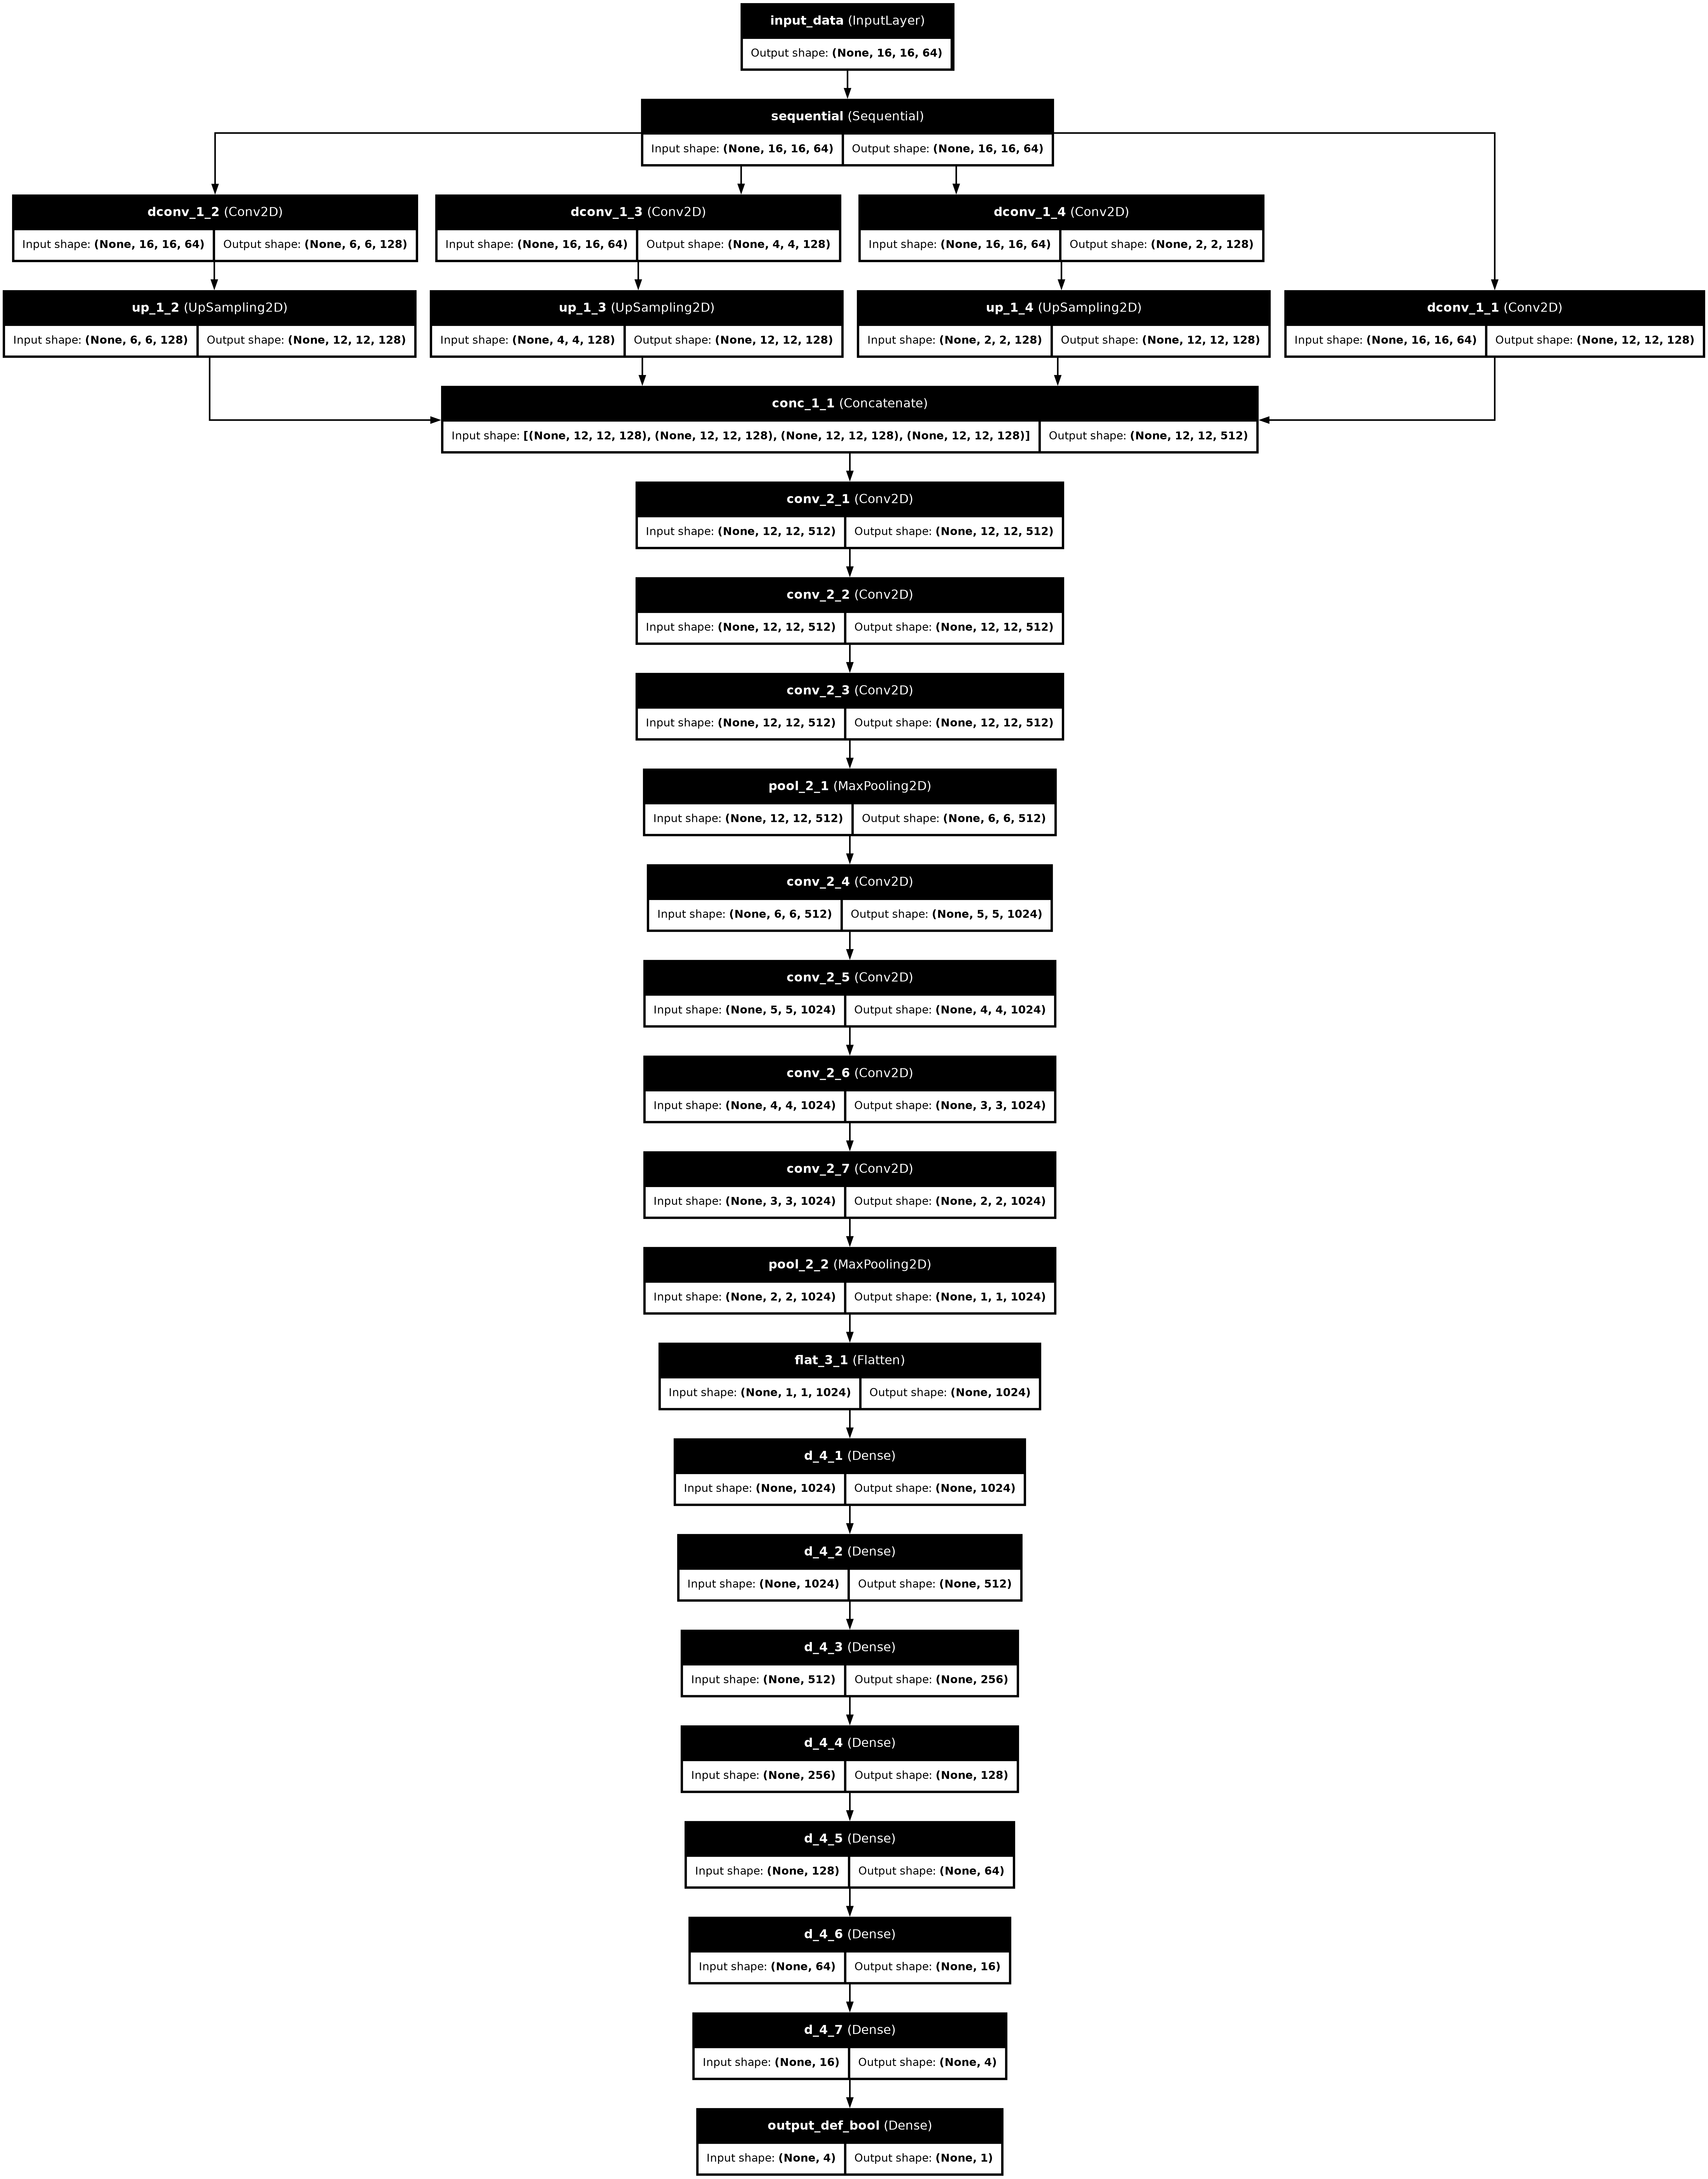

In [9]:
print(model.summary())
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=200,
    show_layer_activations=False,
    show_trainable=False,
)

## Создание и настройка колбэков

In [10]:
callback_params = {
    # остановка обучения если модель перестала учиться
    'EarlyStopping': {
        'monitor': 'val_Recall', # отслеживаемый параметр 
        'min_delta': 0.00001, # минимальное улучшение параметра за cur_patience
        'patience': 10, # кол-во эпох без улучшений
        'restore_best_weights': False,  # сохранять ли веса нейронки с лучшими результатами
    },

    # уменьшение шага сходимости, если модель стала мендленно учиться
    'ReduceLROnPlateau': {
        'monitor' : 'loss', # отслеживаемый параметр 
        'factor' : 0.3, # множитель для расчета нового шага сходимости (new_learning_rate = old_learning_rate*RLPOP_factor)
        'patience' : 1, # кол-во эпох без улучшений
        'verbose' : 0, # выводить ли прогресс изменения шага сходимости в его процессее
        'min_delta' : 0.0001, # порог изменения отслеживаемого значения
        'cooldown' : 2, # количество эпох до возобновления работы после изменения шага сходимости
        'min_lr' : 0 # минимальное значение шага сходимости
    },

    # сохранение весов модели во время обучения
    'ModelCheckpoint': {
        'filepath' : (PATH_TO_SAVE_MODEL/
                      'checkpoints'/
                      f'model_id=v{MODEL_VER:02}n{MODEL_NUM:02}_in({CROP_SIZE}x{CROP_SIZE}x64)_out(1)'/
                      'check-{epoch:04d}.keras'),
        'verbose' : 0,
        'save_freq' : 'epoch'
    },

    'TensorBoard': {
        'log_dir' : (PATH_TO_SAVE_MODEL/
                      'logs'/
                      f'model_id=v{MODEL_VER:02}n{MODEL_NUM:02}_in({CROP_SIZE}x{CROP_SIZE}x64)_out(1)') ,
        'histogram_freq' : 1,
        'write_images' : 1,
        'embeddings_freq' : 1
    },
}

In [11]:
# Создание и настройка колбэков

callback_list = [] # массив колбэков до подачи в колбек "callbacklist"

# остановка обучения если модель перестала учиться
callback_list.append(keras.callbacks.EarlyStopping(**callback_params['EarlyStopping']))

# уменьшение шага сходимости, если модель стала мендленно учиться
callback_list.append(keras.callbacks.ReduceLROnPlateau(**callback_params['ReduceLROnPlateau']))

# запись процесса обучения в логи
callback_list.append(keras.callbacks.TensorBoard(**callback_params['TensorBoard']))

# сохранение весов модели во время обучения
callback_list.append(keras.callbacks.ModelCheckpoint(**callback_params['ModelCheckpoint']))

## Обучение модели

In [12]:
#///////////////////////////////// для тренировки
history = model.fit(dataset['train']['x'], dataset['train']['bin'],
                    batch_size = 4, 
                    epochs = 80, 
                    verbose = 1, 
                    shuffle = True,
                    validation_data = (dataset['val']['x'], dataset['val']['bin']), 
                    callbacks = callback_list)

Epoch 1/80
6375/6375 ━━━━━━━━━━━━━━━━━━━━ 149s 23ms/step - BinaryAccuracy: 0.7908 - FalseNegatives: 2662.7222 - FalsePositives: 10.7760 - MeanSquaredError: 0.1620 - PR_AUC: 0.2750 - Precision: 0.2841 - ROC_AUC: 0.5891 - Recall: 0.0034 - TrueNegatives: 10074.1396 - TruePositives: 6.3620 - loss: 0.5030 - val_BinaryAccuracy: 0.8449 - val_FalseNegatives: 1493.0000 - val_FalsePositives: 0.0000e+00 - val_MeanSquaredError: 0.1204 - val_PR_AUC: 0.4235 - val_Precision: 0.0000e+00 - val_ROC_AUC: 0.7698 - val_Recall: 0.0000e+00 - val_TrueNegatives: 8132.0000 - val_TruePositives: 0.0000e+00 - val_loss: 0.3919 - learning_rate: 0.0050
Epoch 2/80
6375/6375 ━━━━━━━━━━━━━━━━━━━━ 146s 23ms/step - BinaryAccuracy: 0.8029 - FalseNegatives: 2099.0247 - FalsePositives: 411.2218 - MeanSquaredError: 0.1417 - PR_AUC: 0.4458 - Precision: 0.5690 - ROC_AUC: 0.7483 - Recall: 0.1984 - TrueNegatives: 9673.6934 - TruePositives: 570.0594 - loss: 0.4428 - val_BinaryAccuracy: 0.8449 - val_FalseNegatives: 1493.0000 - val_

## Вывод результатов обучение модели

In [13]:
'''FONT_SIZE = 15
for key1,key2 in zip(['BinaryAccuracy','Precision','MeanSquaredError','TruePositives','TrueNegatives'],
                     ['loss','Recall','AUC','FalseNegatives','FalsePositives']):
    fig, axes = plt.subplots(1,2)

    fig.set_figwidth(22)
    fig.set_figheight(8)
    
    axes[0].plot(history.history[key1], 
             label='Train dataset',  linewidth=1.5, color='blue')
    axes[0].plot(history.history[f'val_{key1}'], linestyle = '--', 
             label='Validation dataset',  linewidth=3, color='red')
    axes[0].set_xlabel('Epoch number', fontsize=FONT_SIZE)
    axes[0].set_ylabel(f'{key1} value', fontsize=FONT_SIZE)
    axes[0].set_title(f"Learning process {key1} plot", fontsize=FONT_SIZE, pad=15)
    axes[0].tick_params(axis='both', which='both', labelsize = FONT_SIZE)
    axes[0].minorticks_on()
    axes[0].grid(which='major', linewidth=2)
    axes[0].grid(which='minor', color = 'gray', linestyle = ':')
    axes[0].legend(fontsize = FONT_SIZE, facecolor = "white", loc = 'upper right')

    axes[1].plot(history.history[key2], 
             label='Train dataset',  linewidth=1.5, color='blue')
    axes[1].plot(history.history[f'val_{key2}'], linestyle = '--', 
             label='Validation dataset',  linewidth=3, color='red')
    axes[1].set_xlabel('Epoch number', fontsize=FONT_SIZE)
    axes[1].set_ylabel(f'{key2} value', fontsize=FONT_SIZE)
    axes[1].set_title(f"Learning process {key2} plot", fontsize=FONT_SIZE, pad=15)
    axes[1].tick_params(axis='both', which='both', labelsize = FONT_SIZE)
    axes[1].minorticks_on()
    axes[1].grid(which='major', linewidth=2)
    axes[1].grid(which='minor', color = 'gray', linestyle = ':')
    axes[1].legend(fontsize = FONT_SIZE, facecolor = "white", loc = 'upper right')

    plt.show()'''

'FONT_SIZE = 15\nfor key1,key2 in zip([\'BinaryAccuracy\',\'Precision\',\'MeanSquaredError\',\'TruePositives\',\'TrueNegatives\'],\n                     [\'loss\',\'Recall\',\'AUC\',\'FalseNegatives\',\'FalsePositives\']):\n    fig, axes = plt.subplots(1,2)\n\n    fig.set_figwidth(22)\n    fig.set_figheight(8)\n    \n    axes[0].plot(history.history[key1], \n             label=\'Train dataset\',  linewidth=1.5, color=\'blue\')\n    axes[0].plot(history.history[f\'val_{key1}\'], linestyle = \'--\', \n             label=\'Validation dataset\',  linewidth=3, color=\'red\')\n    axes[0].set_xlabel(\'Epoch number\', fontsize=FONT_SIZE)\n    axes[0].set_ylabel(f\'{key1} value\', fontsize=FONT_SIZE)\n    axes[0].set_title(f"Learning process {key1} plot", fontsize=FONT_SIZE, pad=15)\n    axes[0].tick_params(axis=\'both\', which=\'both\', labelsize = FONT_SIZE)\n    axes[0].minorticks_on()\n    axes[0].grid(which=\'major\', linewidth=2)\n    axes[0].grid(which=\'minor\', color = \'gray\', lines

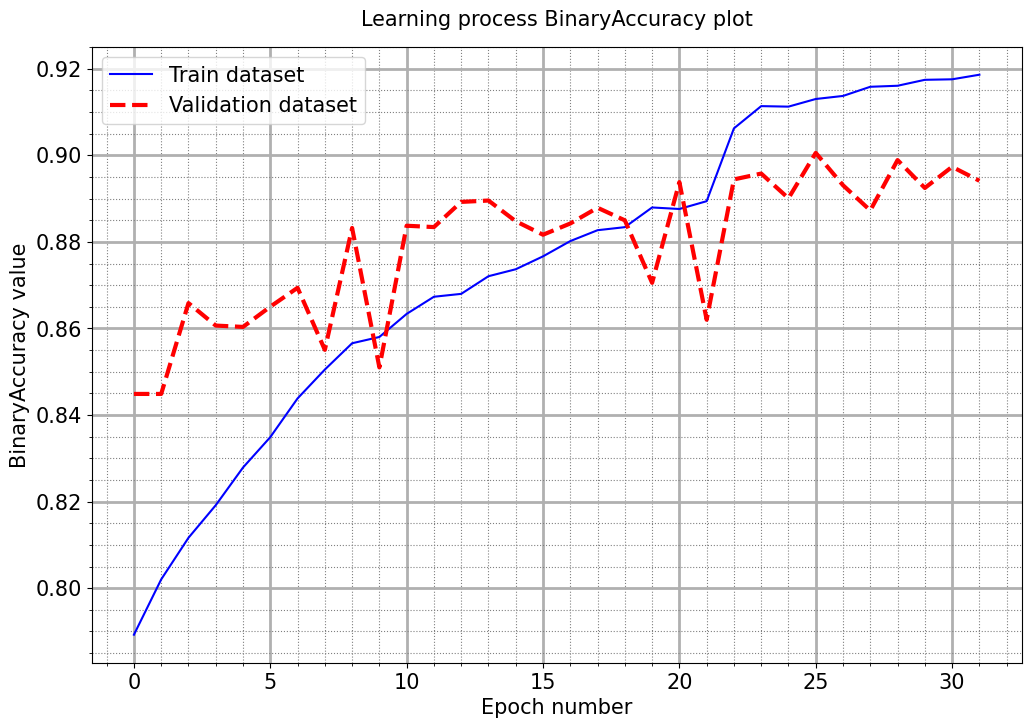

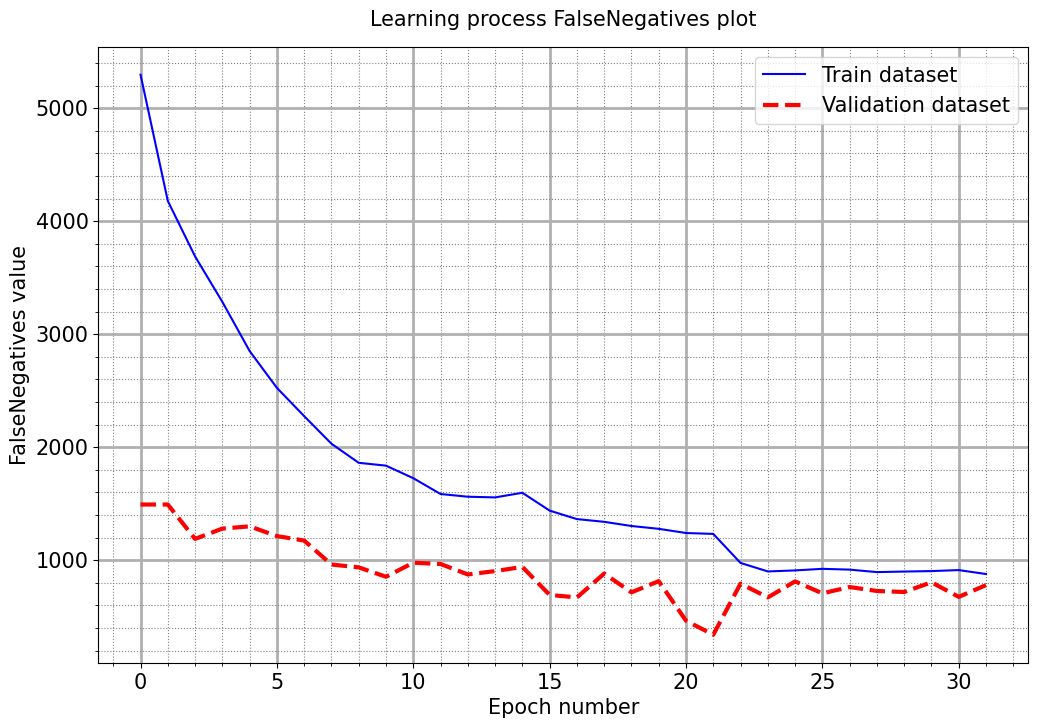

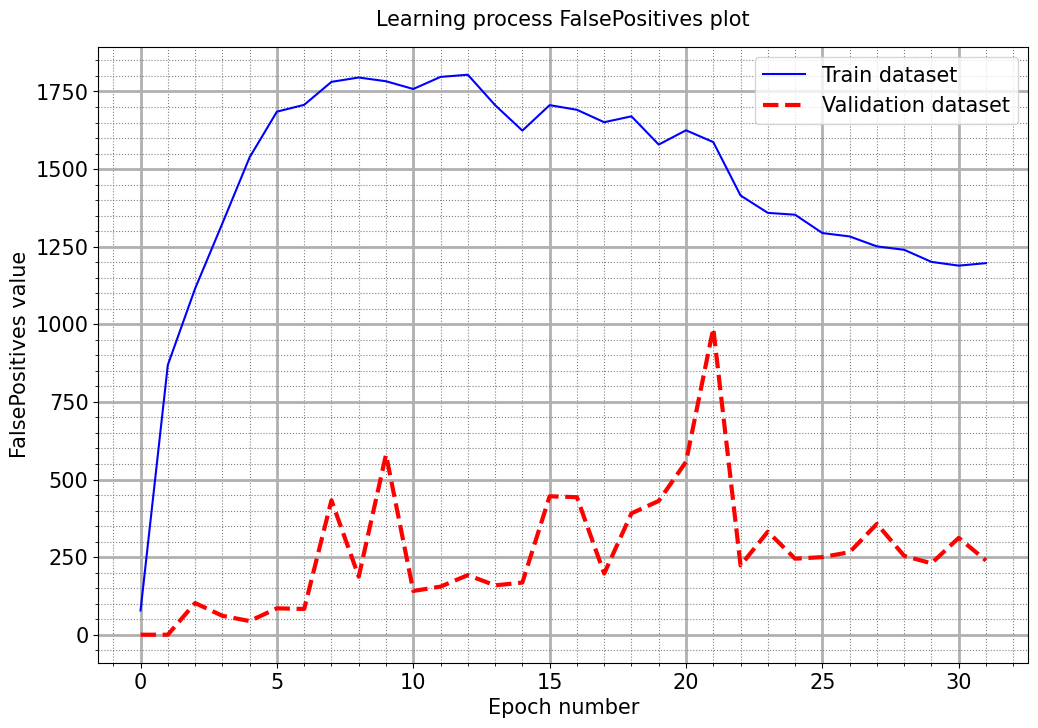

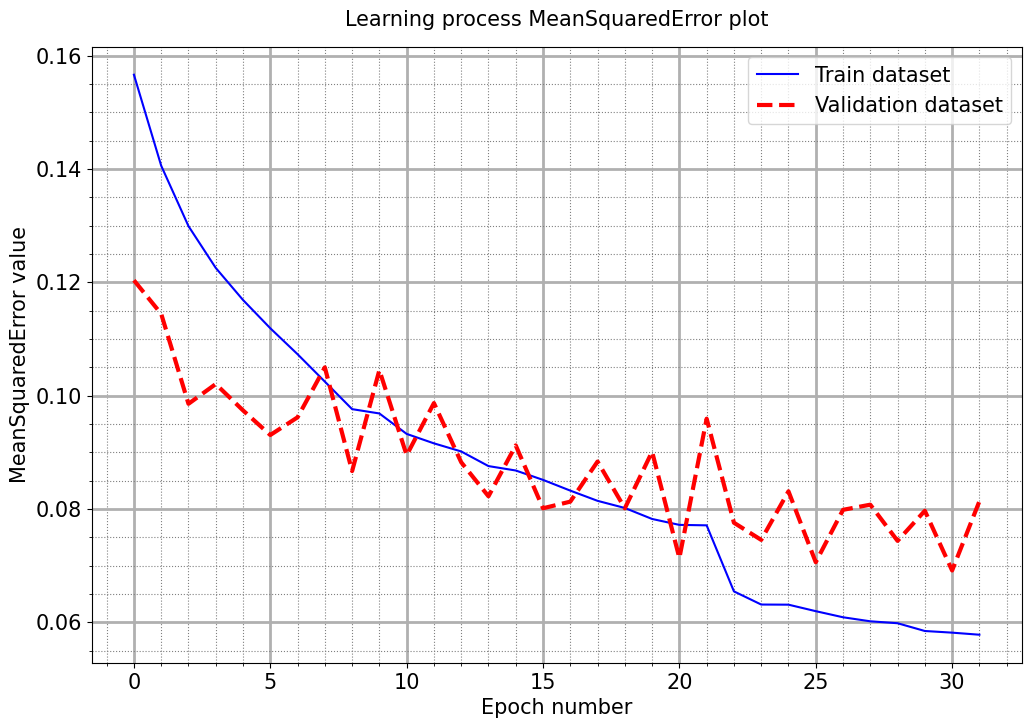

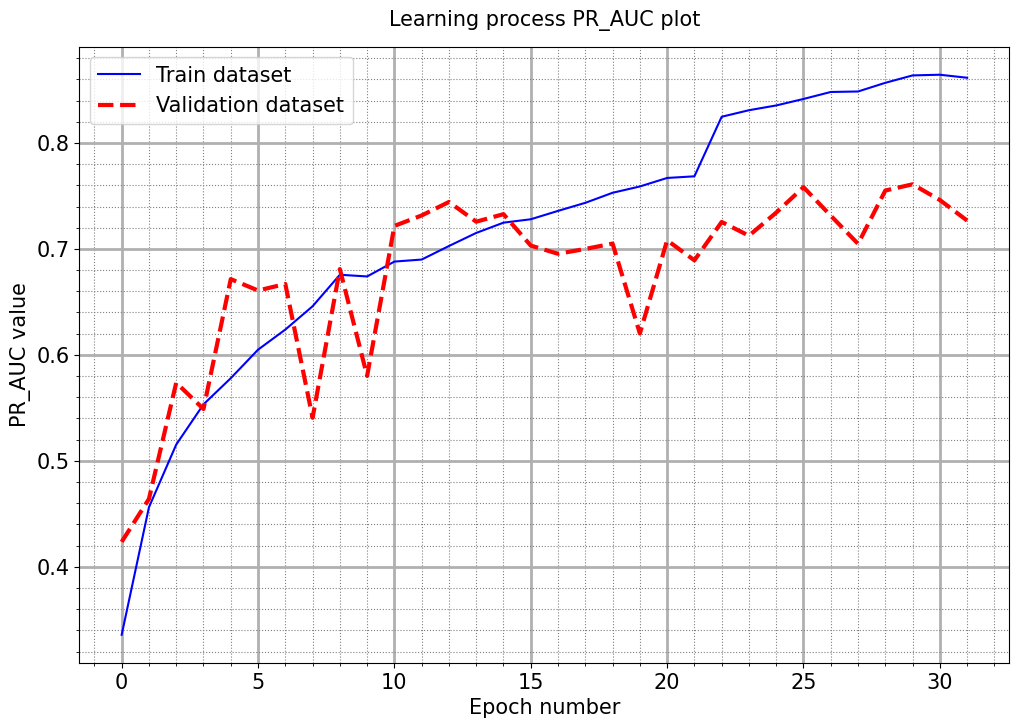

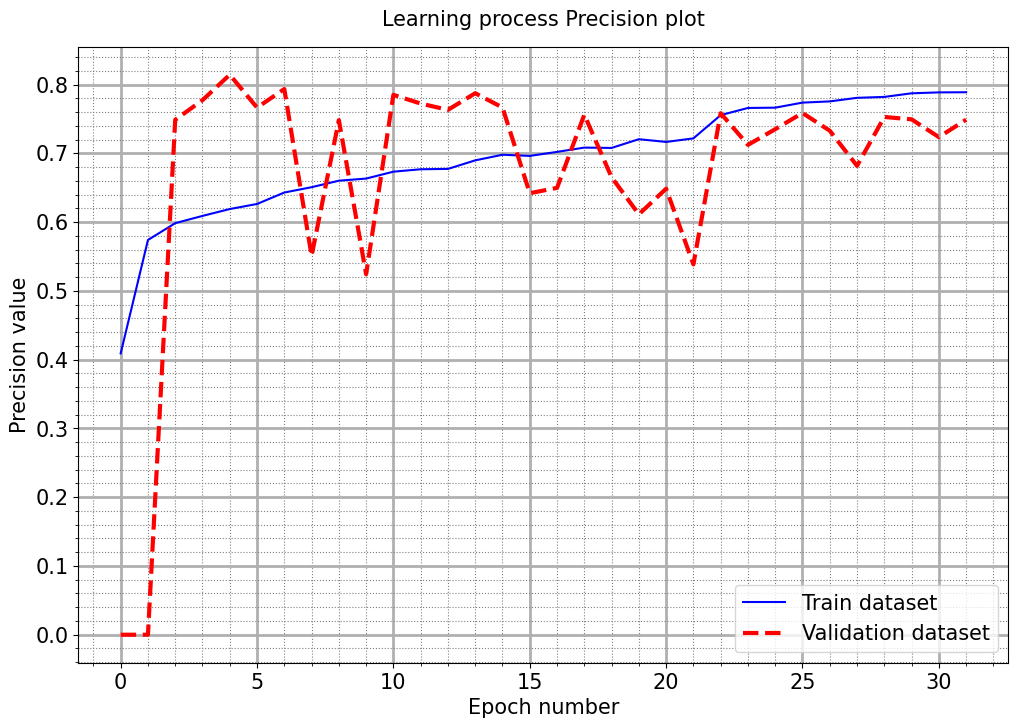

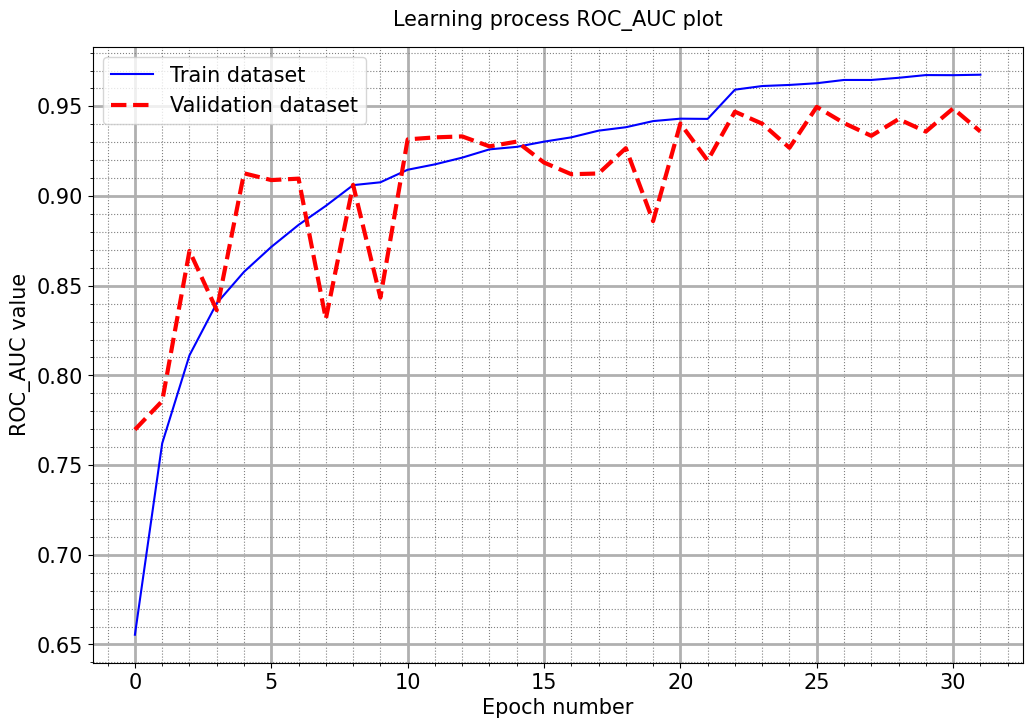

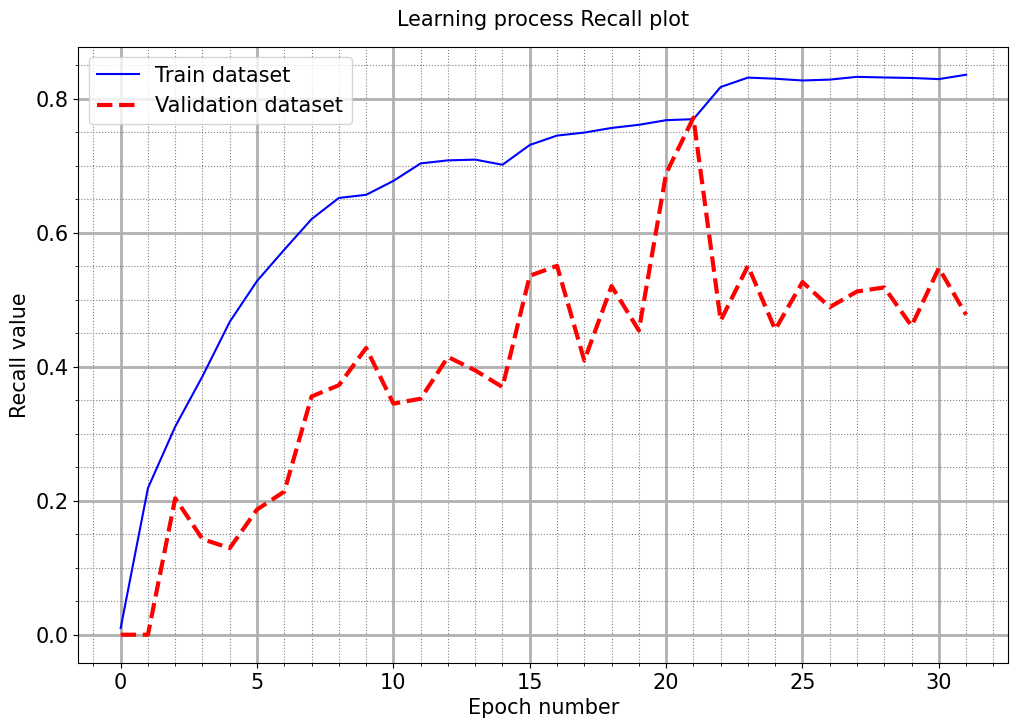

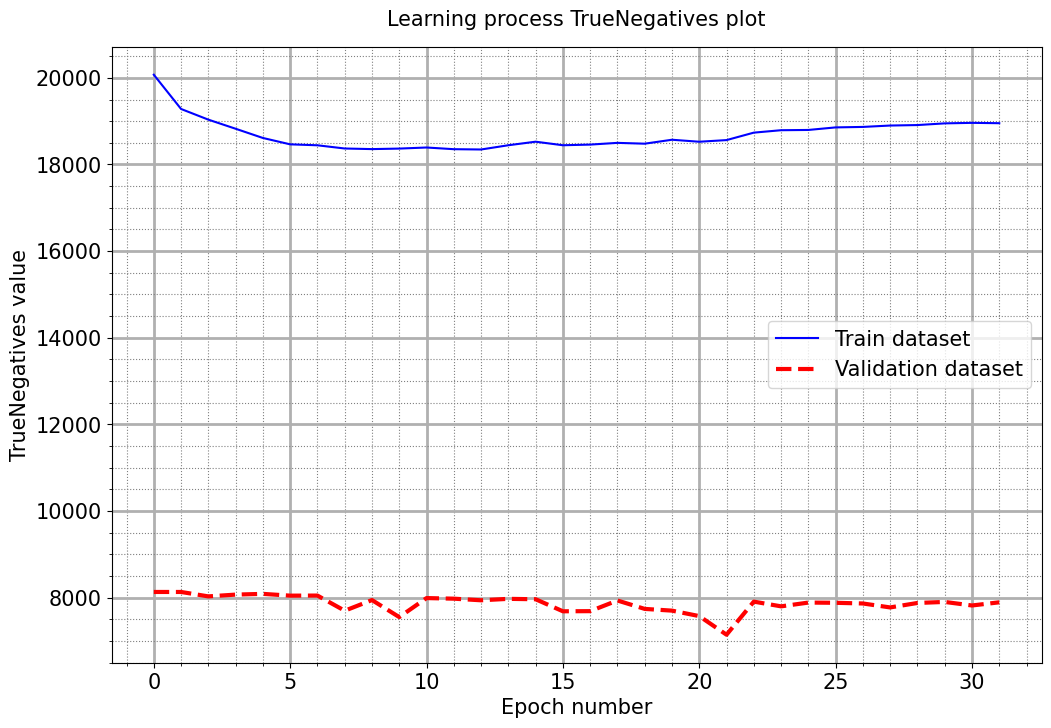

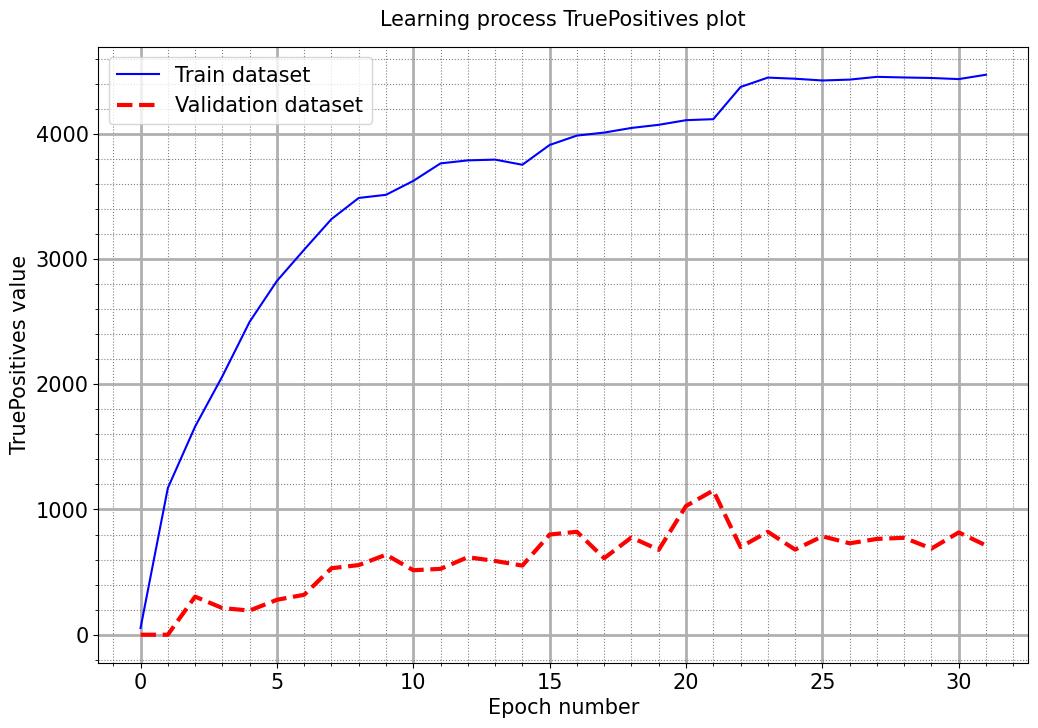

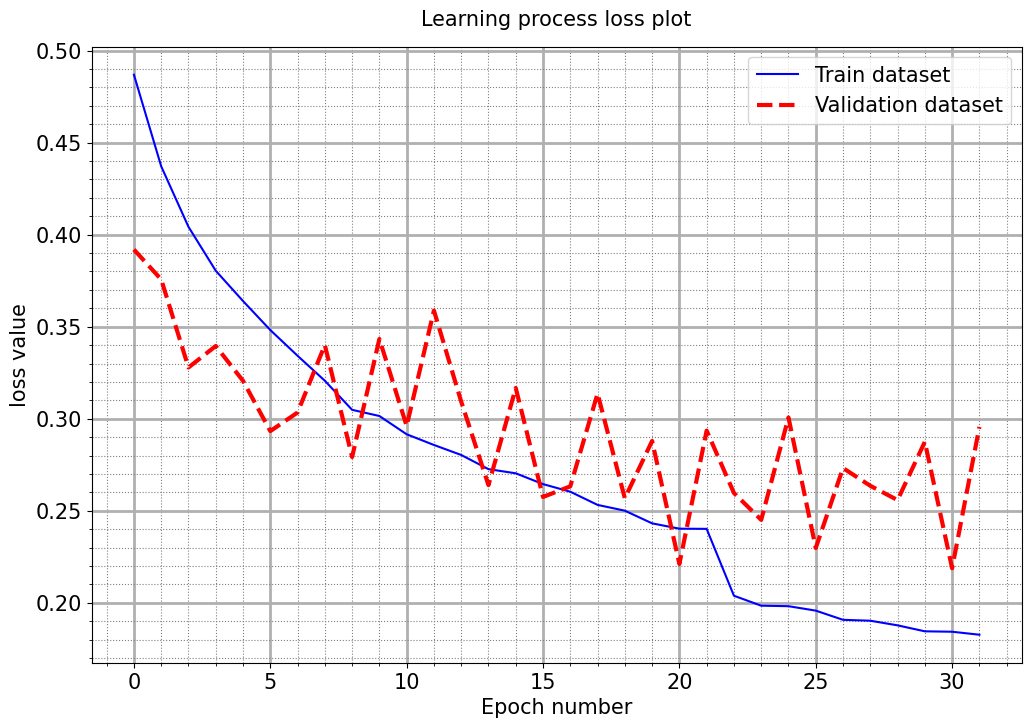

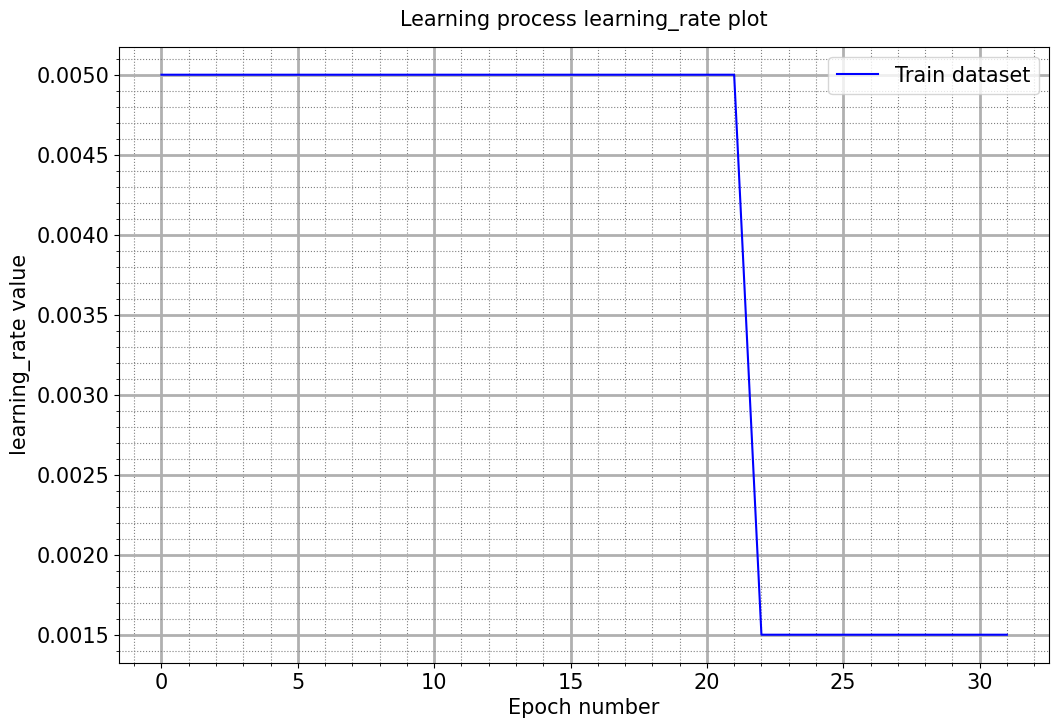

In [18]:
FONT_SIZE = 15
for key in [k for k in history.history.keys() if not k.startswith('val')]:
    fig, ax = plt.subplots()

    fig.set_figwidth(12)
    fig.set_figheight(8)
    
    plt.plot(history.history[key], 
             label='Train dataset',  linewidth=1.5, color='blue')
    if key != 'learning_rate':
        plt.plot(history.history[f'val_{key}'], linestyle = '--', 
             label='Validation dataset',  linewidth=3, color='red')
    
    ax.set_xlabel('Epoch number', fontsize=FONT_SIZE)
    ax.set_ylabel(f'{key} value', fontsize=FONT_SIZE)
    ax.set_title(f"Learning process {key} plot", fontsize=FONT_SIZE, pad=15)
    
    ax.patch.set_alpha(0)
    
    #  Устанавливаем форматирование делений:
    ax.tick_params(axis='both', which='both', labelsize = FONT_SIZE)
    
    # Вывод и настройка сетки
    ax.minorticks_on()
    ax.grid(which='major', linewidth=2)
    ax.grid(which='minor', color = 'gray', linestyle = ':')
    
    ax.legend(fontsize = FONT_SIZE, facecolor = "white")
    
    plt.show()

In [15]:
# сохранинеи процесса обучения в файл
#new_learn_df = pd.DataFrame.from_dict(history.history)
#new_learn_df.to_excel(f"networks/CNN/checkpoints/model_id=v{MODEL_VER}n{NEW_MODEL_NUM}/learning_df.xlsx")

In [16]:
# сохранение модели в файл
#model.save(f"networks/CNN/id=v{MODEL_VER}n{MODEL_NUM}_in({CROP_SIZE}x{CROP_SIZE}x64)_out(1)_train=0dot0_test=0dot0.keras")

#### 